# Training an ANN to represent the gravity produced by a mascon
In this notebook we explore the possibility to use ANNs to represent the generic shape and density of an irregular body represented by a mascon model. The error is defined on the gravitational potential field.

A mascon model is a tuple (points, masses, name) containing the x,y,z position of N points in the unit cube and their masses and the name of the mascon.

To run this notebook (and the others) create a conda environment using the following commands:
```
 conda create -n geodesyann python=3.8 ipython scikit-learn numpy h5py matplotlib jupyter pytorch
 conda activate geodesyann
 conda install -c open3d-admin open3d
 pip install sobol_seq
 pip install tetgen
```


In [1]:
# core stuff
import gravann
import numpy as np
import pickle as pk

# pytorch
from torch import nn
import torch
# For debugging and development purposes this is now set to float64 ... change for speed on GPUs
torch.set_default_tensor_type(torch.DoubleTensor)

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

# Loading and visualizing the ground truth asteroid (a point cloud)

In [2]:
with open("mascons/sample_01_cluster_2400.pk", "rb") as file:
    points, masses, name = pk.load(file)
    
points = torch.tensor(points)
masses = torch.tensor(masses)

    
print("Name: ", name)
print("Number of points: ", len(points))
print("Total mass: ", sum(masses))

Name:  sample_01_cluster_2400
Number of points:  1149
Total mass:  tensor(1.0000)


<IPython.core.display.Javascript object>


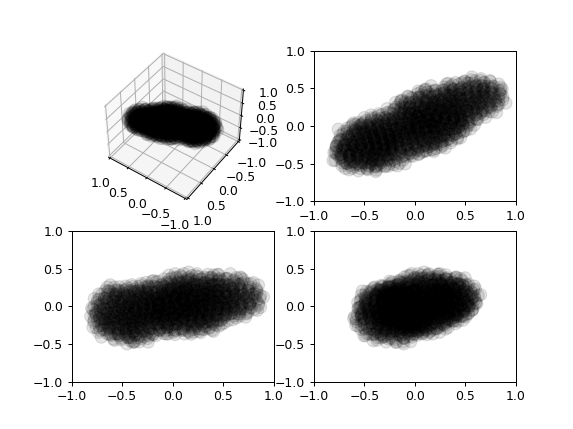

In [3]:
gravann.plot_mascon(points, masses)

# Representing an asteroid via a neural network


## 1 - Instantiating the network
The networks inputs are the cartesian coordinates of a point in the unit cube, encoded via some transformation

In [4]:
# Encoding choosen
encoding = gravann.directional_encoding()

# Network initialization scheme (note that if xavier uniform is used all outputs will start at, roughly 0.5)
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.uniform_(m.bias.data, -0.0, 0.0)

# Network architecture. Note that the dimensionality of the first linear layer must match the output
# of the encoding chosen
n_neurons = 100
model = nn.Sequential(
          nn.Linear(encoding.dim,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,n_neurons),
          nn.ReLU(),
          nn.Linear(n_neurons,1),
          nn.Sigmoid(),
        )

# Applying our weight initialization
_  = model.apply(weights_init)

In [5]:
# IF YOU NOW WANT TO LOAD THE ALREADY TRAINED NETWORK UNCOMMENT HERE.
## It is important that the network architecture is compatible, otherwise this will fail
#model.load_state_dict(torch.load("models/" + name + "_" + encoding.name + ".mdl"))

## Visualizing an asteroid represented by the network
The network output is the density in the unit cube. It is, essentially, a three dimensional function and as such it is difficult to plot. 

### Approach 1: plotting a grid of points colored with the rho value

<IPython.core.display.Javascript object>


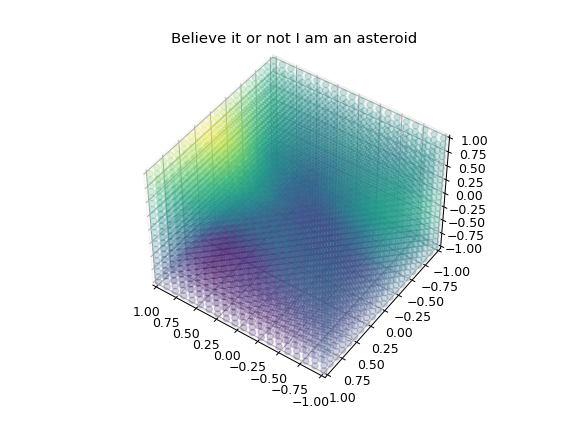

Text(0.5, 0.92, 'Believe it or not I am an asteroid')

In [6]:
gravann.plot_model_grid(model, encoding, views_2d=False)
plt.title("Believe it or not I am an asteroid")

### Approach 2: considering rho as a probability density function and sampling points from it

<IPython.core.display.Javascript object>


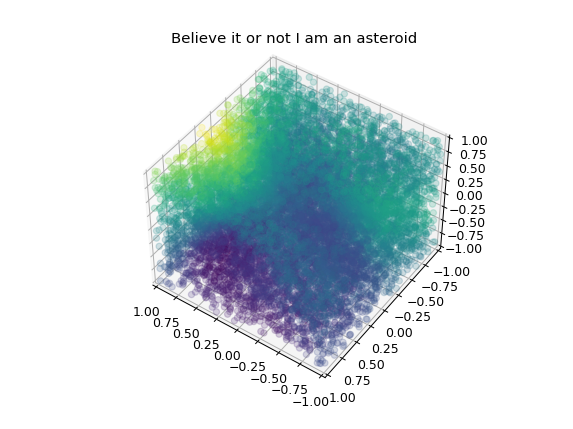

Text(0.5, 0.92, 'Believe it or not I am an asteroid')

In [7]:
gravann.plot_model_rejection(model, encoding, views_2d=False)
plt.title("Believe it or not I am an asteroid")

# Training The ANN to match the ground truth potential

Let it run up to when its < 1e-3 to actually see something that resembles the original asteroid. When stuck increase the number of monte carlo samples or play around the learning rate.

In [8]:
# Here we set the loss
loss_fn = gravann.normalized_loss

# Here we set the choosen Monte Carlo method
mc_method = gravann.U_Pld

# Here we set the optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [9]:
# This is the main training loop
for i in range(5000):
    # At each new epoch we generate new points (its like a new batch), but we make sure
    # they are outside the unit cube
    targets = (torch.rand(100,3)*2-1)*1.1
    a = torch.logical_and((targets[:,0]>-1),(targets[:,0]<1))
    b = torch.logical_and((targets[:,1]>-1),(targets[:,1]<1))
    c = torch.logical_and((targets[:,2]>-1),(targets[:,2]<1))
    d = torch.logical_and(torch.logical_or(a,b), c)
    targets=targets[d]
    labels = gravann.U_L(targets, points, masses)
    
    # Compute the loss (use N=3000 to start with, then, eventually, beef it up to 200000)
    predicted = mc_method(targets, model, encoding, N=10000)
    loss = loss_fn(predicted, labels)
    print(i, loss.item())
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

0 0.06259573422246016
1 0.06278044762556288
2 0.06381020836266402
3 0.040944137694902884
4 0.05396814439603597
5 0.05973354791193612
6 0.06192092864163405
7 0.04672604140371244
8 0.06343968628075346
9 0.06271557508358985
10 0.06198579562521977
11 0.033412220855375534
12 0.052226964002196716
13 0.046246664499347334
14 0.05819708810624595
15 0.06177049968294401
16 0.04178680796893538
17 0.07462727248943898
18 0.05503669023161414
19 0.08102524181157213
20 0.04728573035010683
21 0.04971933310758191
22 0.07107945994238081
23 0.044591307999213424
24 0.07109687167395122
25 0.05439615584180844
26 0.06038899249847712
27 0.0630300438179915
28 0.061861740069080684
29 0.053022908786112516
30 0.05394822818616647
31 0.06652085196518524
32 0.05545958157905221
33 0.056505976187396584
34 0.04817530180212089
35 0.030635159480280564
36 0.08572669858937255
37 0.058844575486296506
38 0.04536632712545801
39 0.07004526519970275
40 0.030755730953645203
41 0.046467016909181924
42 0.059385097501639623
43 0.0556

324 8.602280925859419e-05
325 0.00024393577224314188
326 0.0002470767690782934
327 9.909480360790492e-05
328 0.00016817599822974673
329 0.00020655321692582883
330 0.00013838661510336768
331 9.222075826212318e-05
332 0.0002318425756004104
333 0.00042197848548820367
334 0.0004766899896092378
335 0.00010258026486958888
336 0.00017485689715512646
337 0.00030240352605649255
338 0.00022163721250125716
339 0.0004912076705988721
340 0.0003264732959636315
341 0.0006203064783542439
342 0.000305811209877184
343 0.00024834558268675217
344 0.00017767011134320036
345 0.00030235617174361834
346 0.0002090883682316881
347 0.0003626662085862306
348 0.00046878666884714505
349 0.0004616257905109113
350 0.0003847788636876854
351 0.00018388447642404257
352 0.000152664597406026
353 0.00020768298029698068
354 0.00018870368660964577
355 0.00048308340818179824
356 0.00033605160220099016
357 0.0001389291908490196
358 0.0001414845316663618
359 0.0002651035030150032
360 0.00014248657449944893
361 0.000274519088849

634 0.00023658576039908646
635 9.951533804057962e-05
636 0.00027157929234446665
637 7.020805498696832e-05
638 0.00019252531466972336
639 0.00016937615121424525
640 8.728707289194605e-05
641 0.00015996838431760367
642 0.00017720404963426727
643 2.449195998083098e-05
644 0.00011697007921304664
645 6.316791205980373e-05
646 6.894120536981408e-05
647 0.00010710990989073636
648 9.362950952094928e-05
649 9.702503808927137e-05
650 5.2923093349014575e-05
651 3.933293857247278e-05
652 0.00010400431516914437
653 0.00010410631514813106
654 0.0001764370727364496
655 0.00010210843131622493
656 7.72244241049731e-05
657 7.25072381451348e-05
658 3.6127194427051764e-05
659 0.0001074644421258411
660 0.00010572106476428778
661 5.300492829480868e-05
662 0.001114801603466538
663 0.00019549194378141552
664 3.442961492694512e-05
665 5.177784909970058e-05
666 5.931696368956047e-05
667 3.3087311363687265e-05
668 6.940618177605748e-05
669 0.00011737057999554875
670 7.790793382633753e-05
671 9.133897425425236e-0

946 0.0001011524985225193
947 4.778097876172617e-05
948 5.08889981925658e-05
949 2.4175274558315232e-05
950 6.232445519064869e-05
951 3.7960636556267416e-05
952 7.389027209851767e-05
953 0.00012122638159769212
954 7.005582759429123e-05
955 4.2449651154476957e-05
956 5.3262270537719084e-05
957 4.373895447952816e-05
958 6.075841763998326e-05
959 3.919203959406775e-05
960 6.353015516265037e-05
961 3.4164219380124364e-05
962 3.0015970662027406e-05
963 8.325605692576219e-05
964 2.892757596016573e-05
965 0.00014404869589537962
966 8.330087902596795e-05
967 4.678191271407343e-05
968 6.47913241569998e-05
969 2.332643355841864e-05
970 4.847047270663924e-05
971 8.651641476781739e-05
972 4.088574003836374e-05
973 5.539030888729999e-05
974 6.839276657049675e-05
975 5.8112290628491835e-05
976 0.0003344076373521165
977 4.11926134920831e-05
978 4.880348185292655e-05
979 0.0001190021262127301
980 3.26637255886757e-05
981 0.00015292232185837713
982 0.00010087450877578769
983 1.8983877961772457e-05
984 

1249 4.663397871573766e-05
1250 6.505506692478848e-05
1251 8.880754879676973e-05
1252 5.247174570631746e-05
1253 5.075452833470074e-05
1254 6.909700763710503e-05
1255 4.16688405637411e-05
1256 6.305264278501744e-05
1257 7.906731264632304e-05
1258 4.099808839333005e-05
1259 5.950426895504123e-05
1260 5.6575151951715506e-05
1261 0.00011729741776144691
1262 3.77236779309894e-05
1263 5.154876158007622e-05
1264 3.50221758018309e-05
1265 1.940710231528327e-05
1266 8.086328816263368e-05
1267 2.802077100761474e-05
1268 6.73843934978702e-05
1269 3.1650472703883174e-05
1270 3.014007670708627e-05
1271 5.2004345420742396e-05
1272 7.467848332912167e-05
1273 1.5863706766744454e-05
1274 4.5841685617159526e-05
1275 5.850299854208427e-05
1276 2.4731833239169364e-05
1277 3.929412335261731e-05
1278 6.456992468494993e-05
1279 5.3925428615046134e-05
1280 9.302286873182127e-06
1281 4.914495108647352e-05
1282 3.35418952318545e-05
1283 6.451732510711387e-05
1284 7.09066595063077e-05
1285 3.053542649992379e-05

1550 0.00043810039707570177
1551 6.084311530489383e-05
1552 4.738270080947603e-05
1553 0.00015735101215047566
1554 2.4220619656418582e-05
1555 1.9131861101099043e-05
1556 3.9648496557001745e-05
1557 5.301294566183775e-05
1558 7.514975005697746e-05
1559 3.3316787165440555e-05
1560 8.080065299437522e-05
1561 5.9728544514763975e-05
1562 3.147363017405873e-05
1563 1.993952332153293e-05
1564 0.00010120852700560337
1565 5.8618321189248565e-05
1566 2.0565543150323058e-05
1567 3.342008963659889e-05
1568 2.894826222530516e-05
1569 0.00011376551128493948
1570 5.561479290286007e-06
1571 2.3015596902261582e-05
1572 2.148880558986601e-05
1573 5.529098486984828e-05
1574 5.4860707278022614e-05
1575 3.012929839078326e-05
1576 6.767496140613536e-05
1577 5.806275782665208e-05
1578 3.4755404554792195e-05
1579 2.1608786486781826e-05
1580 4.018798546846772e-05
1581 3.759569682335299e-05
1582 6.04267636559043e-05
1583 0.00011100890329641746
1584 3.173679511234549e-05


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


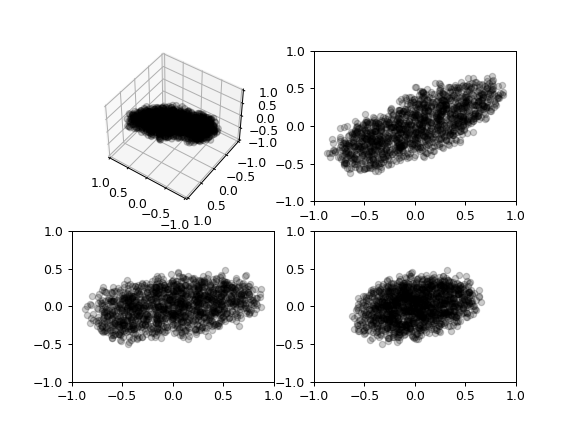

In [11]:
gravann.plot_model_rejection(model, encoding, views_2d=True, bw=True, N=20000, crop_p=0.1)


#### Saving the model

In [170]:
# Uncomment to save to models/cluster_xxxx
# torch.save(model.state_dict(), "models/" + name + "_" + encoding.name + ".mdl")

# TODO list:

* Code efficiency -> move to GPU and make training scalable to more sample points / mc points.
* MC integration -> importance sampling maybe?
* Network architecture -> study different encodings
* How to visualize and interpret the results quantitatively.
* Propagate trajectories around the asteroids (ground truth and trained).
* Incorporate visual cues.
* Training with gravity rather than potential?
* What happens for non uniform bodies?